# Exercise 1:






tekst. her prøver jeg å skrive noe greier . yoyoyo 

# Exercise 2:

In [19]:
%matplotlib inline

import numpy
from astropy import units
from astropy import constants
from astropy.visualization import quantity_support
import matplotlib.pyplot as plt


class Atom:
    """
    Reads atomic data, calculates level populations according to Boltzmann's law,
    and ionisation fractions according to Saha's law.
    """
    
    def __init__(self, atomfile=None):
        """
        Parameters
        ----------
        atomfile : string, optional
            Name of file with atomic data. If not present, atomic data needs
            to be loaded with the .read_atom method.
        """
        self.loaded = False
        if atomfile:
            self.read_atom(atomfile)
        
    def read_atom(self, filename):
        """
        Reads atom structure from text file.
        
        Parameters
        ----------
        filename: string
            Name of file with atomic data.
        """
        tmp = numpy.loadtxt(filename, unpack=True)
        self.n_stages = int(tmp[2].max()) + 1
        # Get maximum number of levels in any stage
        self.max_levels = 0
        for i in range(self.n_stages):
            self.max_levels = max(self.max_levels, (tmp[2] == i).sum())
        # Populate level energies and statistical weights
        # Use a square array filled with NaNs for non-existing levels
        chi = numpy.empty((self.n_stages, self.max_levels))
        chi.fill(numpy.nan)
        self.g = numpy.copy(chi)
        for i in range(self.n_stages):
            nlevels = (tmp[2] == i).sum()
            chi[i, :nlevels] = tmp[0][tmp[2] == i]
            self.g[i, :nlevels] = tmp[1][tmp[2] == i]
        # Put units, convert from cm-1 to Joule
        chi = (chi / units.cm).to('aJ', equivalencies=units.spectral())
        # Save ionisation energies, saved as energy of first level in each stage
        self.chi_ion = chi[:, 0].copy()
        # Save level energies relative to ground level in each stage
        self.chi = chi - self.chi_ion[:, numpy.newaxis]
        self.loaded = True
        
    def compute_partition_function(self, temperature):
        if not self.loaded:
            raise ValueError("Missing atom structure, please load atom with read_atom()")
        temp = temperature[numpy.newaxis, numpy.newaxis]
        return numpy.nansum(self.g[...,numpy.newaxis] * numpy.exp(-self.chi[...,numpy.newaxis]/ constants.k_B/temp),axis=1) #newaxis adds a dimension.
    
    def compute_excitation(self, temperature):
        pfunc = self.compute_partition_function(temperature) #partition func
        # Reshape the arrays
        temp = temperature[numpy.newaxis, numpy.newaxis]
        g_ratio = self.g[...,numpy.newaxis] / pfunc[:,numpy.newaxis]
        chi = self.chi[...,numpy.newaxis]
        return g_ratio * numpy.exp(-chi / (constants.k_B * temp))
    
    def compute_ionisation(self, temperature, electron_pressure):
        partition_function = self.compute_partition_function(temperature)
        electron_density = electron_pressure / (constants.k_B * temperature)
        saha_const = ((2*numpy.pi * constants.m_e * constants.k_B * temperature)/(constants.h**2))**(3/2)
        nstage = numpy.zeros_like(partition_function) / units.m **3
        nstage[0] = 1. / units.m**3
        
        for r in range(self.n_stages - 1):
            nstage[r+1] = (nstage[r] / electron_density * 2 * saha_const * \
                         partition_function[r+1] / partition_function[r] * \
                         numpy.exp(-self.chi_ion[r+1, numpy.newaxis] / (constants.k_B * temperature[numpy.newaxis]))) 
            
        return nstage / numpy.nansum(nstage,axis=0)
    
    def compute_population(self,temperature, electron_pressure):
        
        return (self.compute_excitation(temperature)*self.compute_ionisation(temperature, electron_pressure)[:,numpy.newaxis])
    
    def plot_payne(self,temperature, electron_pressure):
        pops = self.compute_population(temperature, electron_pressure)
        fig,ax = plt.subplots()
        ax.plot(numpy.tile(temp, (self.n_stages,1)).T, pops[:,0].T, 'b-')
        n_levels = self.chi.shape[1]
        if n_levels > 1:
            ax.plot(numpy.tile(temp, (self.n_stages, 1)).T, pops[:,1].T, 'r--')
        if n_levels > 2:
            ax.plot(numpy.tile(temp, (self.n_stages, 1)).T, pops[:,2].T, 'k:')
            
        ax.set_yscale('log')
        ax.set_ylim(1e-4, 1.1)
        ax.set_xlabel("Temperature(K)")
        ax.set_ylabel("Populations")
        

Computing the partition function $U_r$ for T = 5000, 10000 and 20000 K, for Ca:

In [11]:
new_atom = Atom("Ca_atom.txt")
new_atom.compute_partition_function(5000.0 * units.K)  #partition func for 5000 K

<Quantity [[1.16887507],
           [2.19889057],
           [1.        ],
           [4.81535504],
           [6.91357026],
           [2.        ]]>

In [12]:
new_atom.compute_partition_function(10000.0 * units.K) #partition func for 10000 K

<Quantity [[3.45978297],
           [3.55231088],
           [1.        ],
           [5.27699259],
           [8.08152705],
           [2.        ]]>

In [20]:
new_atom.compute_partition_function(20000.0 * units.K) #partition func for 20000 K

<Quantity [[13.62724264],
           [ 6.70523086],
           [ 1.00001079],
           [ 5.5981684 ],
           [ 9.64653685],
           [ 2.        ]]>

The partition function for each stage increases with the temperature, which is what we expect when looking at the expression for $U_r$. 


Plotting the Payne curve for the simplified Ca atom using the same temperature range (100 - 175.000 K) and electron pressure (100 Pa):

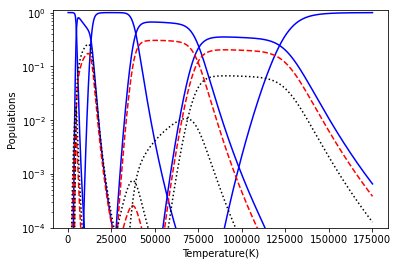

In [23]:
my_atom = Atom("Ca_atom.txt")
temp = numpy.linspace(100,175000,500) * units.K

e_press = 100 * units.Pa
my_atom.plot_payne(temp,e_press)

Plotting the Payne curve for the simplified He atom using the same temperature range (100 - 175.000 K) and electron pressure (100 Pa):

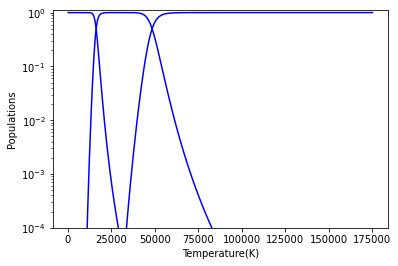

In [25]:
my_atom = Atom("He_atom.txt")
temp = numpy.linspace(100,175000,500) * units.K

e_press = 100 * units.Pa
my_atom.plot_payne(temp,e_press)

When comparing the Payne curves for the Ca atom and the He atom, we observe 